## Imputación de nulos en variables numéricas


Vamos a seguir el mismo flujo de trabajo, para ello sacaremos las columnas que tenemos en nuestro conjunto de datos y luego decidiremos que hacemos con los nulos de cada una de ellas. 


In [12]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

In [13]:
# cargamos el dataframe creado en la lección anterior
df = pd.read_csv("bank-additional_clean_2.csv")
df.head(1)

,income,kidhome,teenhome,dt_customer,numwebvisitsmonth,id,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y,date,latitude,longitude,contact_month,contact_year,age_cat,hijos_totales
0,161770,1,0,2012-04-04,29,089b39d8-e4d0-461b-87d4-814d71e0e079,NaN,housemaid,married,basic 4y,No,No,No,telephone,261,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no,2-agosto-2019,41.495,-71.233,agosto,2019.0,Adultos mayores,1 hijos


In [17]:
# Obtenemos la lista de columnas numericas que tienen nulos
nulos_esta_num = df[df.columns[df.isnull().any()]].select_dtypes(include = np.number).columns
print("Las columnas numéricas que tienen nulos son : \n ")
print(nulos_esta_num)

Las columnas numéricas que tienen nulos son : 
 
Index(['age', 'pdays', 'conspriceidx', 'euribor3m', 'contact_year'], dtype='object')


In [18]:
# lo primero que vamos a hacer es calcular el número de nulos que tenemos en cada una de las columnas numericas
df[nulos_esta_num].isnull().sum() / df.shape[0]

age             0.119070
pdays           0.963070
conspriceidx    0.010953
euribor3m       0.215256
contact_year    0.005767
dtype: float64

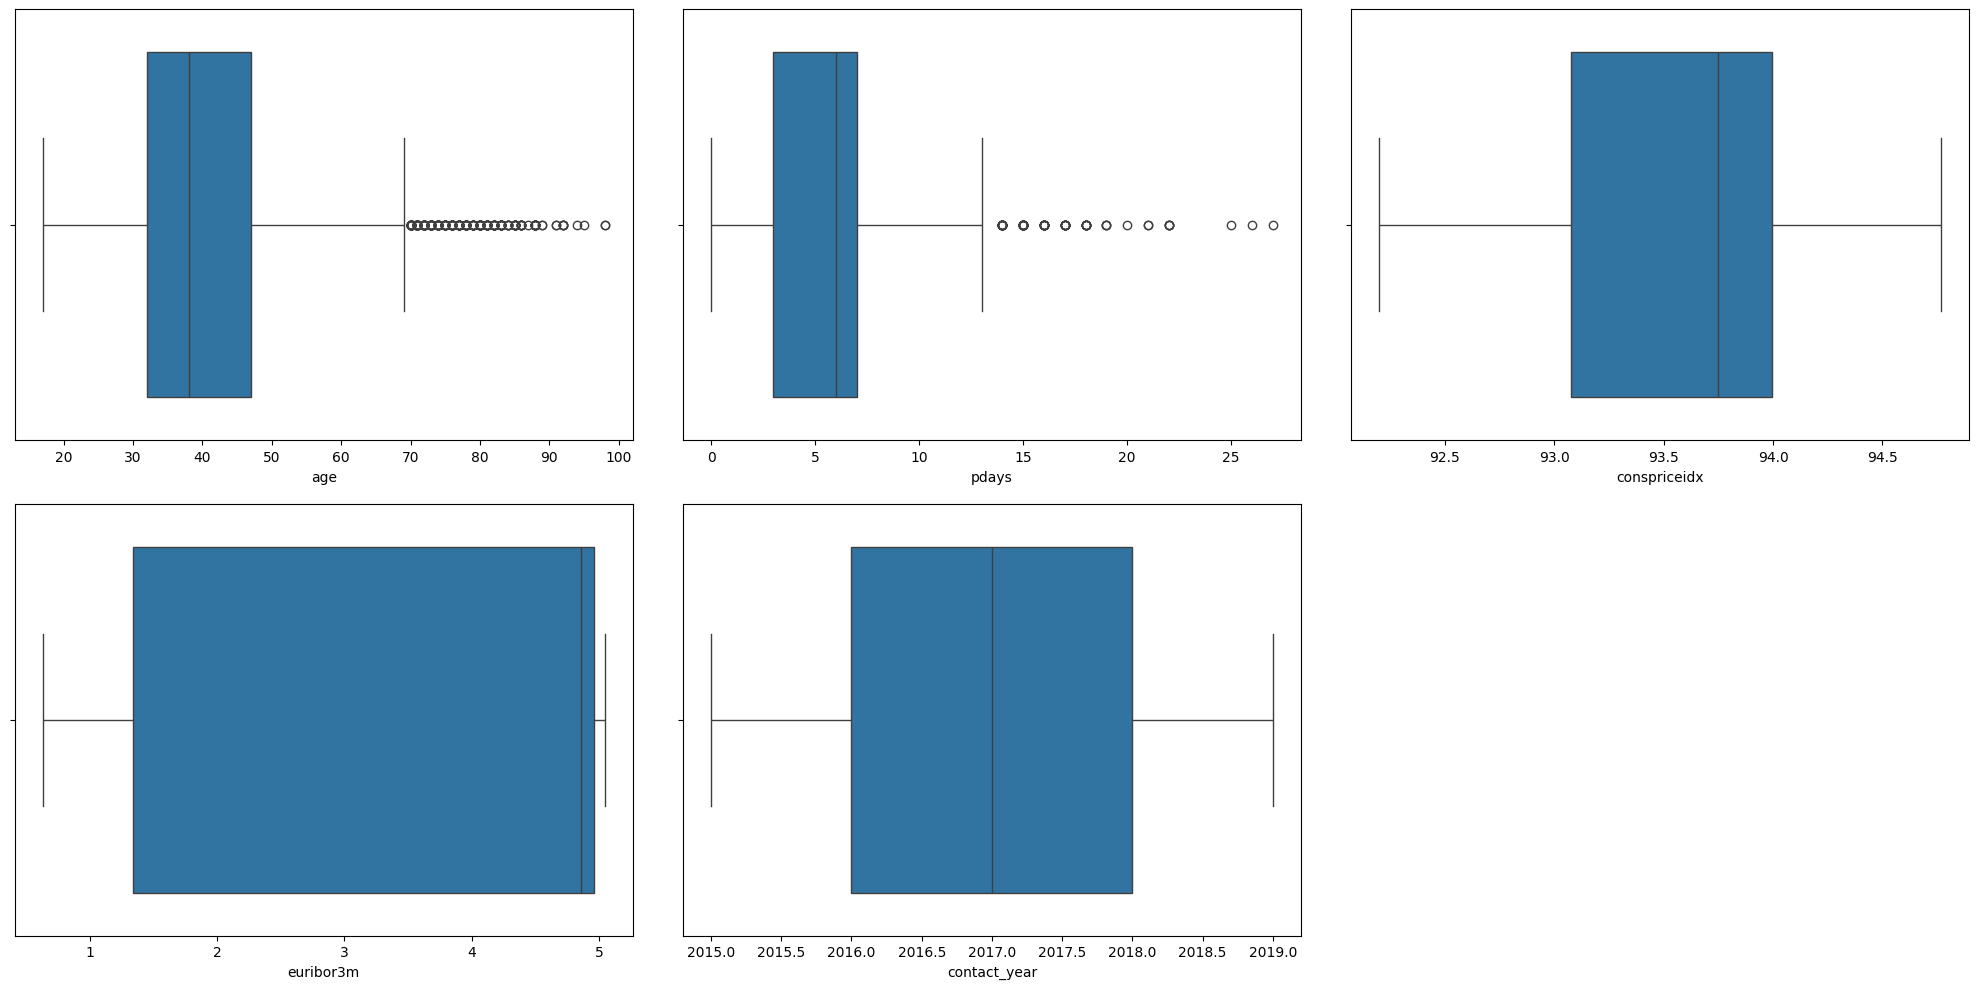

In [19]:
# lo siguiente que tendríamos que hacer es ver si dentro de las columnas donde tenemos nulos tenemos valores atípicos. 
# Para hacer esto lo mejor es usar visualización, sin embargo, todavía no hemos aprendido (lo haremos mañana). 
# Por lo tanto, el código que tenéis a continuación no es necesario que lo entendais. 

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10)) 

axes = axes.flat

for indice, col in enumerate(nulos_esta_num):
    sns.boxplot(x = col, data = df, ax = axes[indice])
    
plt.tight_layout()
fig.delaxes(axes[-1]);

¿Cómo identificamos los *outliers* o valores atípicos en las columnas? Son todos aquellos puntos que se ven más allá de los bigotes de las gráficas, por lo tanto, tenemos valores atípicos en las columnas de `age` y `pdays`. Sobre los *outliers* hablaremos mas en profundidad más adelante, sin embargo, si queréis profundizar más en detalle os dejamos [este](https://support.minitab.com/es-mx/minitab/20/help-and-how-to/graphs/general-graph-options/graph-editing-basics/identifying-outliers/)  artículo. 

Vemos ahora como nos enfrentaremos a la gestión de cada una de las columnas:

- `conspriceidx` y `contact_year` tienen valores por debajo del 5-10% por lo que optaremos por reemplazar por la media o mediana. Para eso usaremos: 

    - Para la columna `conspriceidx` usaremos el método `.fillna()`

    - Para la columna `contact_year` usaremos el método `SimpleImputer` de Sklearn. 

    La diferencia entre el *fillna* y el *SimpleImputer* solo esta en el código ya que ambos reemplazar por la media o la mediana sin utilizar ningún método más avanzado. 

- `age` y `pdays`: ambas columnas tienen valores atípicos por lo que optaremos por reemplazar los nulos con métodos más avanzados como KNNImputer y IterativeImputer. A modo de herramienta docente aplicaremos los dos métodos a las dos columnas y veremos si hay diferencias o no. 

- `euribor3m`: en este caso tenemos un porcentaje alto de nulos, por lo que optaremos por reemplazar los nulos con métodos avanzados, lo haremos con los métodos para que, al igual que en el caso de las columnas de `age` y `pdays` podamos comparar.  

In [20]:
# la primera columna que gestionaremos sera 'conspriceidx' usando el método 'fillna()' que ya conocemos
# calculamos la media para la columna 'conspriceidx'
media_conspriceidx = df["conspriceidx"].mean()
print(f"La media de la columna 'conspriceidx' es: {round(media_conspriceidx, 2)}")

# aplicamos el método 'fillna()' a la columna
df["conspriceidx"] = df["conspriceidx"].fillna(media_conspriceidx)

# comprobamos los nulos para la columna
print(f"Después del 'fillna' tenemos {df['conspriceidx'].isnull().sum()} nulos")

La media de la columna 'conspriceidx' es: 93.57
Después del 'fillna' tenemos 0 nulos


Vamos ahora con la columna de `contact_year` que hemos dicho que usaríamos el SimpleImputer. Entendamos antes qué hace y cuál es su sintaxis: 

El `SimpleImputer` es una clase de la librería scikit-learn que se utiliza para reemplazar valores faltantes en conjuntos de datos mediante diferentes estrategias estadísticas. Estas estrategias incluyen el reemplazo por **la media, la mediana, la moda o un valor constante** (fijaos que hace exactamente que el *fillna*). 
La sintaxis básica para utilizar `SimpleImputer` es la siguiente:

```python
# Crear una instancia del SimpleImputer
imputer = SimpleImputer(strategy, fill_value)

# Ajustar y transformar los datos
data_imputed = imputer.fit_transform(datos)
```

Donde:
- `strategy`: Es el argumento que determina la estrategia que se utilizará para reemplazar los valores faltantes. Puede ser 'mean' (media), 'median' (mediana), 'most_frequent' (moda) o 'constant' (constante).

- `datos`: Columna(s) que contienen los  valores faltantes.

- `fill_value` (opcional): Solo se usará si la estrategía que usamos es "constant". Sirve para especificar el valor constante que se utilizará para reemplazar los valores faltantes, por ejemplo  "Unknown", lo que hara será reemplazar por "Unknown" todos los valores nulos. 


In [21]:
# imputamos los nulos de la columna ' contact_year' usando SimpleImputer empezando con la instancia del método donde tendremos que especificar la estrategía que queremos usar
# para decidir si usamos la media o la mediana lo que haremos es hacer un describe de la columna para saber cuales son estos valores
df["contact_year"].describe()[["mean", "50%"]]

mean    2017.00131
50%     2017.00000
Name: contact_year, dtype: float64

**¿Cómo sabremos si es mejor reemplazar por la media o la mediana?**

Primero recordemos estos conceptos: 

- **Media:** Es simplemente el promedio de todos los valores en un conjunto de datos. Usar la media para llenar valores faltantes puede ser útil cuando nuestros datos están distribuidos de manera bastante uniforme y no hay valores extremadamente altos o bajos que puedan afectar significativamente la media.

- **Mediana:** Es el valor que se encuentra justo en el medio de un conjunto de datos ordenado. Usamos la mediana cuando nuestros datos están sesgados o tienen valores atípicos, es decir, valores extremos que no siguen la tendencia general de los demás datos.

Imaginemos que estamos analizando los salarios de un grupo de personas. Si tenemos un par de salarios extremadamente altos en comparación con el resto del grupo, la media podría verse afectada y no representaría adecuadamente la mayoría de los salarios. En este caso, sería más sensato usar la mediana, ya que no se ve afectada por los valores atípicos y proporciona una mejor idea de cuál es el salario típico.

En resumen, si nuestros datos son relativamente uniformes y no hay valores atípicos significativos, la media puede ser una buena elección. Sin embargo, si nuestros datos tienen valores atípicos o están sesgados, la mediana es más robusta y nos dará una mejor estimación del valor central en nuestros datos.

> Nota: Podremos saber si los datos están sesgados o no comparando la media y la mediana, si las diferencias entre ellas son muy grandes podríamos decir que si que están sesgados y que por lo tanto sería mejor utilizar la mediana. 

En nuestro caso como la media y la mediana son muy parecidas usaremos la media para imputar los nulos con el método SimpleImputer. 


In [23]:
# creamos el objeto de la clase del SimpleImputer
imputer_contact_year = SimpleImputer(strategy = "mean")

# ajustamos y transformamos los datos. 📌 Fijaos como hemos puesto dos corchetes en el nombre de la columna
contact_year_imputado = imputer_contact_year.fit_transform(df[["contact_year"]])

# comprobamos que es lo que nos devuelve este método. Nos devuelve un array. 
contact_year_imputado

array([[2019.],
       [2016.],
       [2019.],
       ...,
       [2016.],
       [2019.],
       [2019.]], shape=(43000, 1))

In [24]:
# lo siguiente que tenemos que hacer es introducir este array en nuestro DataFrame, en este caso sobreescribiremos la columna original. 
df["contact_year"] = contact_year_imputado

# por último comprobamos si tenemos nulos. 
print(f"Después del 'SimpleImputer' tenemos {df['contact_year'].isnull().sum()} nulos")

Después del 'SimpleImputer' tenemos 0 nulos


Es el turno de las columnas de `age` y `pdays`, para los cuales ibamos a usar los métodos IterativeImputer y KNNImputer. Entendamos qué hacen, y cuál es su sintaxis. 

**Iterative Imputer** 

La sintaxis para usar `IterativeImputer` es:

```python
# Crear una instancia del IterativeImputer
imputer = IterativeImputer(max_iter, random_state)

# Ajustar y transformar los datos
data_imputed = imputer.fit_transform(datos)
```
**KNN Imputer**

Vamos a ver cómo usar el `KNNImputer` en scikit-learn:

```python
# Crear una instancia del KNNImputer
imputer = KNNImputer(n_neighbors=n_vecinos)

# Ajustar y transformar los datos
data_imputed = imputer.fit_transform(datos)
```

In [25]:
# como vamos a crear columnas nuevas, vamos a hacer una copia del DataFrame usando el método 'copy()'
df_copia = df.copy()
df_copia.head(1)

,income,kidhome,teenhome,dt_customer,numwebvisitsmonth,id,age,job,marital,education,default,housing,loan,contact,duration,campaign,pdays,previous,poutcome,empvarrate,conspriceidx,consconfidx,euribor3m,nremployed,y,date,latitude,longitude,contact_month,contact_year,age_cat,hijos_totales
0,161770,1,0,2012-04-04,29,089b39d8-e4d0-461b-87d4-814d71e0e079,NaN,housemaid,married,basic 4y,No,No,No,telephone,261,1,NaN,0,nonexistent,1.1,93.994,-36.4,4.857,5191,no,2-agosto-2019,41.495,-71.233,agosto,2019.0,Adultos mayores,1 hijos


In [27]:
# hemos dicho que para las tres columnas restantes aplicaremos los dos métodos para luego compararlos, empezaremos por el IterativeImputer
# instanciamos las clases
imputer_iterative = IterativeImputer(max_iter = 20, random_state = 42)

# ajustamos y tranformamos los datos
imputer_iterative_imputado = imputer_iterative.fit_transform(df_copia[["age", "pdays", "euribor3m"]])

# comprobamos que es lo que nos devuelve, que en este caso es un array también
imputer_iterative_imputado

array([[40.00543619,  0.9089466 ,  4.857     ],
       [57.        ,  1.65203854,  3.60317415],
       [37.        ,  1.08344612,  4.857     ],
       ...,
       [39.98804013,  2.65048232,  3.59541316],
       [40.00682893,  0.76952289,  4.958     ],
       [39.9939082 ,  2.06298835,  4.021     ]], shape=(43000, 3))

In [29]:
# en este caso como vamos a aplicar los dos métodos sobre estas columnas vamos a crear dos columnas nuevas
df_copia[["age_iterative", "pdays_iterative", "euribor_iterative"]] = imputer_iterative_imputado

# comprobamos los nulos
print(f"Después del 'Iterative' tenemos: \n{df_copia[['age_iterative', 'pdays_iterative', 'euribor_iterative']].isnull().sum()} nulos")

Después del 'Iterative' tenemos: 
age_iterative        0
pdays_iterative      0
euribor_iterative    0
dtype: int64 nulos


In [30]:
# hagamos ahora lo mismo con el KNNImputer. NOTA, la ejecución de esta celda puede tardar un ratito

# instanciamos la clase del KNNImputer
imputer_knn = KNNImputer(n_neighbors = 5)

# ajustamos y transformamos los datos
imputer_knn_imputado = imputer_knn.fit_transform(df_copia[["age", "pdays", "euribor3m"]])

# comprobamos que es lo que nos devuelve, que sigue siendo un array
imputer_knn_imputado

array([[38.2       ,  4.4       ,  4.857     ],
       [57.        ,  4.8       ,  4.2286    ],
       [37.        ,  7.        ,  4.857     ],
       ...,
       [39.97711193,  6.07241814,  3.61652074],
       [34.6       ,  4.4       ,  4.958     ],
       [42.4       ,  3.6       ,  4.021     ]], shape=(43000, 3))

In [31]:
# por último nos queda añadir ese array al DataFrame como hemos hecho hasta ahora
df_copia[["age_knn", "pdays_knn", "euribor_knn"]] = imputer_knn_imputado


# comprobamos los nulos
print(f"Después del 'KNN' tenemos: \n{df_copia[['age_knn', 'pdays_knn', 'euribor_knn']].isnull().sum()} nulos")

Después del 'KNN' tenemos: 
age_knn        0
pdays_knn      0
euribor_knn    0
dtype: int64 nulos


Solo nos queda comparar con cual de los dos métodos que acabamos de aprender para ver cual se ajusta mejor a los datos. Para eso lo que haremos será trabajar desde el 'describe()'  para ver si los estadísticos antes y después de la inputación no han cambiado mucho. Finalmente nos quedaremos con aquel método que modifique los estadísticos menos. 

In [32]:
df_copia.describe()[["age","age_iterative", "age_knn", "pdays", "pdays_iterative", "pdays_knn", "euribor3m", "euribor_iterative", "euribor_knn"]]

,age,age_iterative,age_knn,pdays,pdays_iterative,pdays_knn,euribor3m,euribor_iterative,euribor_knn
count,37880.000000,43000.000000,43000.000000,1588.000000,43000.000000,43000.000000,33744.000000,43000.000000,43000.000000
mean,39.977112,39.988040,39.856609,6.072418,2.650482,6.031405,3.616521,3.595413,3.600595
std,10.437957,9.933618,9.919913,3.863182,2.330438,1.951291,1.737117,1.567801,1.591854
min,17.000000,-50.903756,17.000000,0.000000,-0.577994,0.000000,0.634000,-12.678706,0.634000
25%,32.000000,33.000000,32.000000,3.000000,0.907566,4.600000,1.344000,1.445000,1.435000
50%,38.000000,39.955946,38.800000,6.000000,1.828094,5.800000,4.857000,4.076000,4.222800
75%,47.000000,46.000000,46.000000,7.000000,4.000000,7.000000,4.961000,4.959000,4.959000
max,98.000000,98.000000,98.000000,27.000000,27.000000,27.000000,5.045000,5.830842,5.045000


Analizemos los resultados: 

- En el caso de la columna de `age` nos fijamos que ni la media ni la mediana son muy diferentes entre la columna original, la imputada con el Iterative y la imputada con el KNN, por lo tanto cualquiera de los dos métodos serían correctos para imputar los nulos. 

- En el caso de `pdays` vemos que con el iterative si cambia mucho la media y la mediana, por lo que sería el método menos apropiado y nos quedaríamos con la imputación con KNN. 

- En el caso de `euribor3m` estamos en la misma situación que con la edad, por lo tanto, cualquiera de los dos métodos serían válidos. 

In [33]:
# ante esta situación, vamos a eliminar las columnas que ya no nos interesan para guardar el DataFrame para la lección de mañana. 
# en nuestro caso eliminaremos, "age", "padays", "euribor3m" (porque tienen nulos), "age_knn" y "euribor_knn" (porque para estas columnas podríamos haber eliminado cualquiera de las columnas derivadas de la imputación) y "pdays_iterative" (porque hemos visto que es la que peor imputaba los nulos)

df_copia.drop(["age", "pdays", "euribor3m", "age_knn" , "euribor_knn",  "pdays_iterative" ], axis = 1, inplace = True)

# ahora vamos a cambiar el nombre de las columnas que quedaron para que tengan el mismo nombre de origen
nuevo_nombre = {"age_iterative": "age",  'euribor_iterative': "euribor3m", "pdays_knn": "pdays"   }
df_copia.rename(columns = nuevo_nombre, inplace = True)

In [34]:
# Guardamos el DataFrame para usarlo en la lección de mañana 
df_copia.to_csv("bank-additional-clean-nonulls.csv",index=False)